In [1]:
import os
from concurrent.futures import ProcessPoolExecutor

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from uf3.data import io
from uf3.data import geometry
from uf3.data import composition
from uf3.representation import bspline
from uf3.representation import distances
from uf3.representation import process
from uf3.regression import least_squares
from uf3.forcefield import calculator
from uf3.forcefield import lammps
from uf3.util import parallel
from uf3.util import plotting

# $\text{UF}_{2}$ Demo: Elemental tungsten

**Data split**
- Training set: 1939 configurations (stratified 20% of the dataset)

- Holdout: 7754 configurations (remaining 80%)

**Inputs**
- ```w-14.xyz``` (30 mb)
- ```training_idx.txt``` (10 kb, included for reproducibility purposes)

**Outputs**
- ```model_pair.json``` (1 kb)
- ```W_pair.table``` (32 kb)

In [4]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

 Step             | Estimated Time 
:-----------------|:--------------
Preprocessing     | 10 seconds
Pair distribution | 10 seconds
Featurization     | 5 core-minutes (parallelizable)
Training          | 1 second
Prediction        | 1 second
Plotting          | 9 seconds

# User Parameters

```element_list (list)```: list of element symbols

```degree (int)```: truncation of many-body expansion. A value of 2 yields a pair potential.

In [5]:
element_list = ['W']
degree = 2

Initialize the ```ChemicalSystem``` and inspect interactions.

Elements involved in each interactions are sorted by electronegativity.

In [6]:
chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)
print("Pairs:", chemical_system.interactions_map[2])

Pairs: [('W', 'W')]


```r_min_map (dict)```: map of minimum pair distance per interaction (angstroms). 
    If unspecified, defaults to 1.0 for all interactions.
    
```r_max_map (dict)```: map of maximum pair distance per interaction (angstroms). 
    If unspecified, defaults to 6.0 angstroms for all interactions, which probably encompasses at least 2nd-nearest neighbors.
    
```resolution_map (dict)```: map of resolution (number of knot intervals) per interaction. 
    For the cubic basis, the number of basis functions equals three more than the number of knot intervals.
    This is, in turn, negated by ```trailing_trim```.
    If unspecified, defaults to 20 for all two-body interactions and 5 for three-body interactions.
    
```trailing_trim (int)```: number of trailing basis functions to trim, defaults to 3.
 - ```= 0```: hard cutoff at ```r_max```
 - ```= 1```: function goes to zero at ```r_max```
 - ```= 2```: first derivative goes to zero at ```r_max```
 - ```= 3```: second derivative goes to zero at ```r_max```

In [7]:
r_min_map = {('W', 'W'): 1.5,
            }
r_max_map = {('W', 'W'): 5.5,
            }
resolution_map = {('W', 'W'): 25,
                 }
trailing_trim = 3

# Demo parameters
```n_cores```: number of workers to use in parallel for feature generation

```data_filename```: filename of reference data including geometries, energies, forces, ...

```training_1939```: list of integers corresponding to entries to use for training.

In [8]:
n_cores = 4

In [9]:
example_directory = os.getcwd()
data_filename = os.path.join(example_directory, "w-14.xyz")
with open(os.path.join(example_directory, "training_idx.txt"), "r") as f:
    training_1939 = [int(idx) for idx in f.read().splitlines()]

# Initialize basis

In [10]:
bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

```bspline_config.get_interaction_partitions()``` yields the number of coefficients for each n-body interaction (one-body terms, two-body terms, three-body terms, ...) as well as the starting index in the coefficient vector for each interaction.

In [11]:
bspline_config.get_interaction_partitions()[0]

{'W': 1, ('W', 'W'): 28}

In [12]:
bspline_config.get_interaction_partitions()[1]

{'W': 0, ('W', 'W'): 1}

# Load data

In [13]:
data_coordinator = io.DataCoordinator()
data_coordinator.dataframe_from_trajectory(data_filename,
                                           prefix='dft')
df_data = data_coordinator.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))

Number of energies: 9693
Number of forces: 475578


In [14]:
df_data.head()

,geometry,energy,fx,fy,fz,size
dft_0,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.194835,[0.0],[0.0],[0.0],1.0
dft_1,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.126991,[0.0],[0.0],[0.0],1.0
dft_2,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.133282,[0.0],[0.0],[0.0],1.0
dft_3,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.139626,[0.0],[0.0],[0.0],1.0
dft_4,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.142003,[0.0],[0.0],[0.0],1.0


Useful step that serves as a sanity check for selected cutoffs and resolution.

# Examine pair distance distribution

In [15]:
atoms_key = data_coordinator.atoms_key
histogram_slice = np.random.choice(np.arange(len(df_data)),
                                   min(1000, len(df_data)),
                                   replace=False)
df_slice = df_data[atoms_key].iloc[histogram_slice]
histograms = distances.summarize_distances(df_slice,
                                           chemical_system,
                                           min_peak_width=0.2)

  0%|          | 0/1000 [00:00<?, ?it/s]

('W', 'W') Lower bound: 1.920 angstroms
('W', 'W') Peaks (min width 0.2 angstroms): [5.22 6.9  9.42]


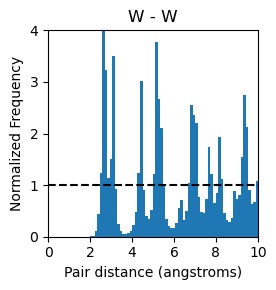

In [16]:
bar_width = histograms[1][1] - histograms[1][0]
pairs = chemical_system.interactions_map[2]
fig, ax = plt.subplots(1, len(pairs), figsize=(len(pairs)*3, 3), dpi=100)
if not isinstance(ax, (list, np.ndarray)):
    ax = [ax]
for i, pair in enumerate(pairs):
    ax[i].bar(histograms[1][:-1],
              histograms[0][pair],
              width=bar_width)
    ax[i].set_title(" - ".join(pair))
    ax[i].plot([0, 10], [1, 1], linestyle='--', color='k')
    ax[i].set_xlim(0, 10)
    ax[i].set_ylim(0, 4)
    ax[i].set_xlabel("Pair distance (angstroms)")
    ax[i].set_ylabel("Normalized Frequency")
fig.tight_layout()

# Compute energy and force features

In [17]:
representation = process.BasisFeaturizer(chemical_system,
                                         bspline_config)

In [18]:
client = ProcessPoolExecutor(max_workers=n_cores)

In [19]:
n_batches = n_cores * 16  # added granularity for more progress bar updates
df_features = representation.evaluate_parallel(df_data,
                                               client,
                                               energy_key=data_coordinator.energy_key,
                                               n_jobs=n_batches)

  0%|          | 0/64 [00:00<?, ?it/s]

In [20]:
df_features.head()

y  n_W  ij_0  ij_1  ij_2  ij_3  ij_4  ij_5  ij_6  \
dft_0 energy -11.194835  1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      fx_0     0.000000  0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0   
      fy_0     0.000000  0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0   
      fz_0     0.000000  0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0   
dft_1 energy -11.126991  1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                      ij_7  ...         ij_18         ij_19         ij_20  \
dft_0 energy  5.465031e-03  ...  3.641680e-02  3.884511e+00  7.278707e+00   
      fx_0    6.938894e-18  ... -8.326673e-17 -4.440892e-16  4.440892e-16   
      fy_0   -0.000000e+00  ... -0.000000e+00 -4.440892e-16 -0.000000e+00   
      fz_0    6.938894e-18  ...  2.775558e-17 -0.000000e+00 -2.220446e-16   
dft_1 energy  2.732517e-03  ...  1.609307e-02  2.028756e+00  5.999376e+00   

                     ij_21     ij_22         ij_23         ij_24  ij_25  \
dft_0 energy  8.003649e-01  0.000000  2.774099e-01  1.012363e+01    0.0   
      fx_0   -0.000000e+00 -0.000000 -3.053113e-16 -2.220446e-16   -0.0   
      fy_0    2.220446e-16 -0.000000 -0.000000e+00  2.220446e-16   -0.0   
      fz_0   -0.000000e+00 -0.000000 -3.330669e-16 -1.332268e-15   -0.0   
dft_1 energy  3.438647e+00  0.516544  2.634127e-01  5.359363e+00    0.0   

              ij_26  ij_27  
dft_0 energy    0.0    0.0  
      fx_0     -0.0   -0.0  
      fy_0     -0.0   -0.0  
      fz_0     -0.0   -0.0  
dft_1 energy    0.0    0.0  

[5 rows x 30 columns]

# Fit model

In [21]:
regularizer = bspline_config.get_regularization_matrix(ridge_1b=1e-6,
                                                       curvature_2b=1e-8)

model = least_squares.WeightedLinearModel(bspline_config,
                                          regularizer=regularizer)

Train with 20% of the dataset (1939 samples)

In [22]:
training_keys = df_data.index[training_1939]
df_slice = df_features.loc[training_keys]
n_elements = len(chemical_system.element_list)
x_e, y_e, x_f, y_f = least_squares.dataframe_to_tuples(df_slice,
                                                       n_elements=n_elements,
                                                       energy_key="energy")

# Fit with energies and force

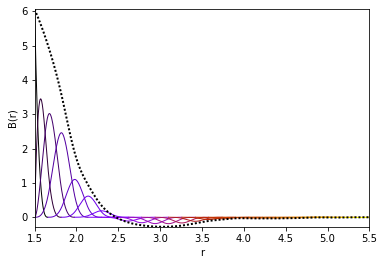

In [23]:
model.fit(x_e, y_e, x_f, y_f, weight=0.5)
solutions = least_squares.arrange_coefficients(model.coefficients, 
                                               bspline_config)
coefficients = solutions[("W", "W")]
knot_sequence = bspline_config.knots_map[("W", "W")]
fig, ax = plotting.visualize_splines(coefficients, knot_sequence)

# Prediction

In [24]:
# predict with remaining 80% of dataset
holdout_keys = df_data.index.difference(training_keys)

In [25]:
df_holdout = df_features.loc[holdout_keys]
x_e, y_e, x_f, y_f = least_squares.dataframe_to_tuples(df_holdout,
                                                       n_elements=n_elements,
                                                       energy_key="energy")

In [26]:
p_e = model.predict(x_e)

In [27]:
p_f = model.predict(x_f)

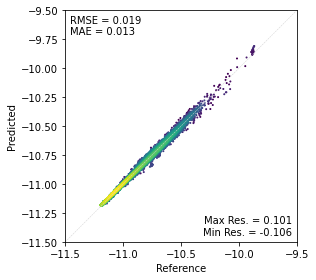

In [28]:
plotting.density_scatter(y_e, p_e)
plt.tight_layout()

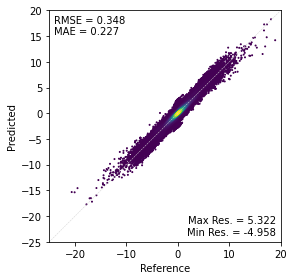

In [29]:
plotting.density_scatter(y_f, p_f)
plt.tight_layout()

In [30]:
solutions = least_squares.arrange_coefficients(model.coefficients, 
                                               bspline_config)

In [31]:
for interaction, values in solutions.items():
    print(interaction, ":", values)

W : -7.3598176211137485
('W', 'W') : [ 6.05292109e+00  5.76172773e+00  5.06058534e+00  3.69113116e+00
  1.65205853e+00  9.23859149e-01  2.81258201e-01 -5.36413556e-03
 -1.65669972e-01 -2.39954884e-01 -2.77954263e-01 -2.80998799e-01
 -2.49653066e-01 -1.77409590e-01 -1.00099852e-01 -6.82599769e-02
 -2.00034440e-02 -3.28071234e-02 -3.43219435e-02 -3.43618259e-02
 -2.88400639e-02 -2.12175439e-02 -6.90983502e-04 -9.25139031e-03
 -8.08694792e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]


# Export potential and tabulated potential

In [32]:
model.save("model_pair.json")

In [33]:
table_list = []
pair_list = chemical_system.interactions_map[2]
for pair in pair_list:
    text = lammps.export_tabulated_potential(representation.knots_map[pair],
                                             solutions[pair],
                                             pair,
                                             grid=1000,
                                             filename=None)
    table_list.append(text)
combined_text = "\n\n\n".join(table_list)
table_name = os.path.join(example_directory, "table_test", "W.table")
with open(table_name, "w") as f:
    f.write(combined_text)

# Compute energy, forces, stress with UFCalculator

In [34]:
calc = calculator.UFCalculator(bspline_config, model)

geom = df_data.iloc[3000]['geometry'].copy()  # 12-atom cell
geom.set_calculator(calc)
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
print("Forces:\n", geom.get_forces())
print("Max force:", np.max(np.abs(geom.get_forces())))

Energy: [-129.90850437]
Stresses (numerical): [-0.07157686 -0.05615776 -0.03585433  0.00072185 -0.01699741 -0.03629823]
Forces:
 [[ 0.36706937 -7.28026397  0.58103694]
 [ 1.10934562  0.51625161 -0.62697603]
 [-1.15703167 -1.59575223 -0.37736722]
 [-1.83079162  5.43204632 -0.44976142]
 [ 0.57471404  2.30500838  1.01534022]
 [ 1.86237115 -2.25965517 -0.7613154 ]
 [ 2.60550322  1.55873367 -0.90440522]
 [-1.66154524 -0.61688415  1.17963061]
 [-2.14010085 -0.27336131  0.10013569]
 [ 0.09055564  5.6471755   0.11915614]
 [ 1.97460374 -3.39727663 -0.23972051]
 [-1.79469339 -0.03602202  0.3642462 ]]
Max force: 7.280263968421663


# Compare with UFLammps calculator

In [35]:
calc = lammps.UFLammps(lmpcmds=["pair_style table spline 1000",
                                "pair_coeff * * table_test/W.table UF_W-W 5.5"],
                       keep_alive=True)
geom = df_data.iloc[3000]['geometry'].copy()  # 12-atom cell
geom.set_calculator(calc)
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
print("Forces:\n", geom.get_forces())
print("Max force:", np.max(np.abs(geom.get_forces())))
del calc

Energy: -41.59071629828812
Stresses (numerical): [-0.07157678 -0.05615798 -0.03585438  0.0007219  -0.01699733 -0.0362982 ]
Forces:
 [[-0.36707085  7.28027149 -0.58103072]
 [-1.10934726 -0.51625373  0.62697386]
 [ 1.15703129  1.59575361  0.37736717]
 [ 1.830793   -5.4320507   0.44975813]
 [-0.57471276 -2.30501251 -1.01534688]
 [-1.86236869  2.25965632  0.76131392]
 [-2.60550385 -1.55873187  0.90440782]
 [ 1.66154317  0.61688455 -1.17962671]
 [ 2.14010237  0.27336506 -0.10013918]
 [-0.0905544  -5.64717482 -0.11915727]
 [-1.97460007  3.39727246  0.23972502]
 [ 1.79468806  0.03602015 -0.36424515]]
Max force: 7.280271486255797


# Relax with UFLammps calculator

In [36]:
calc = lammps.UFLammps(lmpcmds=["pair_style table spline 1000",
                                "pair_coeff * * table_test/W.table UF_W-W 5.5"],
                       keep_alive=True)
calc.relax(geom)
print('Relaxation Steps:', calc.results['nsteps'])
geom.calc = calc
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
lammps_forces = geom.get_forces()
print("Forces:\n", lammps_forces)
print("Max force:", np.max(lammps_forces))
del calc

Relaxation Steps: 93
Energy: -44.93448967579233
Stresses (numerical): [-0.02876663 -0.00625577  0.03505017  0.00253287 -0.01604888 -0.03666763]
Forces:
 [[-6.13670874e-04 -5.59840158e-04 -1.20723586e-04]
 [ 2.10592823e-03 -2.35684886e-04 -1.86147363e-03]
 [ 2.02430711e-03  9.13033147e-04 -4.07057512e-05]
 [-2.62411174e-03  2.23662760e-04  9.79704229e-04]
 [-1.35599262e-03  7.35322985e-05  8.57665172e-04]
 [ 1.69965025e-03 -2.32461582e-04 -1.11735158e-03]
 [ 2.73562177e-03 -4.59016302e-04 -1.12265584e-03]
 [-2.76851036e-03  7.63081639e-04  1.39608060e-03]
 [-6.43108653e-04  4.58048485e-05  8.62789598e-04]
 [ 7.53828171e-04 -8.23463358e-04  3.07237588e-04]
 [-2.56944163e-04 -2.46499874e-04 -3.66001987e-04]
 [-1.05699711e-03  5.37851469e-04  2.25435193e-04]]
Max force: 0.0027356217678128417
